<font size=5>Reinforcement Learning to Control a Robot</font>

In this assignment, you will play with a simulation of a two-dimensional robot arm with multiple links and joints. You will train a neural network to approximate the Q function.

The state of the arm is just the angles of each joint.  To remove the huge difference between joint angles of 359 degrees and 1 degree as a joint moves, we will represent each joint angle with two values, the sine and cosine of the angle, as the state input to the neural network. Valid actions on each step will be $-0.1$, $0$, and $+0.1$ applied to each joint.


#### Assignment 6
#### Suman Bhatta

# `Robot` class

Here is an implementation of the robot simulation.

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import sys
import itertools  # for product (cross product)
from math import pi
from IPython.display import display, clear_output


Now import your `NeuralNetwork` regression class that uses `numpy` and has the `scg` optimizer available.

In [2]:
import A3mysolution as nn  # where you implement the NeuralNetwork class

In [5]:
class Robot():

    def __init__(self, link_lengths):
        self.n_links = len(link_lengths)
        self.record_angles = False
        self.angles = []
        self.link_lengths = np.array(link_lengths)
        self.joint_angles = np.zeros(self.n_links)
        self.points = [[10, 10] for _ in range(self.n_links + 1)]
        self.lim = sum(link_lengths)
        self.update_points()
        self.goal = None

    def set_goal(self, g):
        self.goal = g

    def dist_to_goal(self):
        return np.sqrt(np.sum((self.goal - self.end_effector)**2))
    
    def update_joints(self, joint_angles):
        self.joint_angles = joint_angles
        self.update_points()

    def add_to_joints(self, joint_angle_deltas):
        self.joint_angles += joint_angle_deltas
        too_high = self.joint_angles > 2 * pi
        self.joint_angles[too_high] = self.joint_angles[too_high] - 2 * pi
        too_low = self.joint_angles < 0
        self.joint_angles[too_low] = self.joint_angles[too_low] + 2 * pi
        if self.record_angles:
            self.angles.append(self.joint_angles * 180 / pi)
        self.update_points()

    def update_points(self):
        for i in range(1, self.n_links + 1):
            self.points[i][0] = (self.points[i - 1][0]
                                 + self.link_lengths[i - 1] * np.cos(np.sum(self.joint_angles[:i])))
            self.points[i][1] = (self.points[i - 1][1] +
                                 self.link_lengths[i - 1] * np.sin(np.sum(self.joint_angles[:i])))
        self.end_effector = np.array(self.points[self.n_links]).T

    def get_angles(self):
        return self.joint_angles
    

    def plot(self, style):
        for i in range(self.n_links + 1):
            if i is not self.n_links:
                plt.plot([self.points[i][0], self.points[i + 1][0]],
                         [self.points[i][1], self.points[i + 1][1]], style)
            plt.plot(self.points[i][0], self.points[i][1], 'k.')
        plt.axis('off')
        plt.axis('square')
        plt.xlim([-1, 21])
        plt.ylim([-1, 21])

    def animate(self, n_steps, Qnet=None, show_all_steps=False):
        fig = plt.figure(figsize=(8, 8))
        
        for i in range(n_steps):
            if not show_all_steps:
                fig.clf()
            plt.scatter(self.goal[0], self.goal[1], s=80)
            if Qnet:
                action, Qvalue = epsilon_greedy(self, Qnet, valid_actions, epsilon=0)
            else:
                action = [0.1] * self.n_links
            self.add_to_joints(action)
            style = 'b-' if show_all_steps and i+1 == n_steps else 'r-'
            self.plot(style)
            
            if not show_all_steps:
                clear_output(wait=True)
                display(fig)
            
        if not show_all_steps:
            clear_output(wait=True)

To use this class, first instantiate a robot by specifying the number of links and the lengths of each link as a list.  Imagine the end of the last link of the robot has a gripper. Set the goal location for the gripper by calling `robot.set_goal()`.  

Then you can animate the robot for some number of steps.

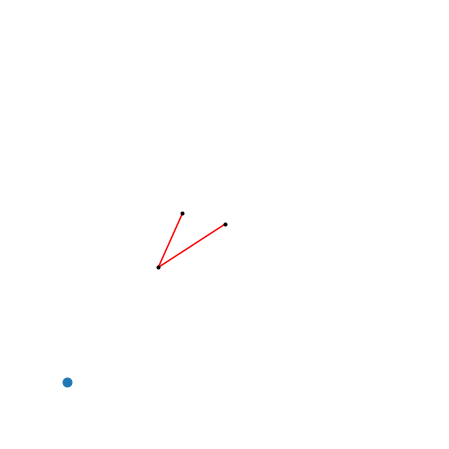

In [6]:
robot = Robot([4, 3])
robot.set_goal([2, 2])
robot.animate(100)

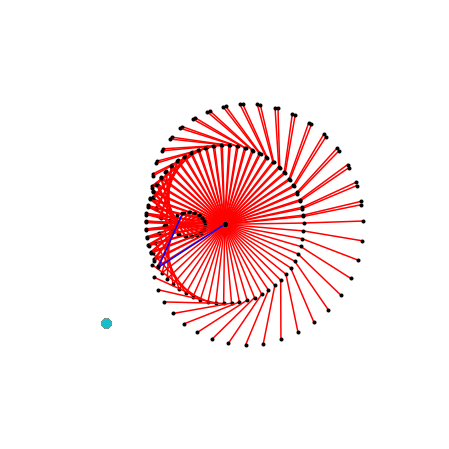

In [7]:
robot = Robot([4, 3])
robot.set_goal([4, 5])
robot.animate(100, show_all_steps=True)

# Reinforcement Learning Problem for Controlling the Robot

To define the reinforcement learning problem for controlling this robot, and trying to move the gripper as close to the goal as you can, we need to define the three main functions that define a reinforcement learning problem.  These are pretty easy with the functions available to us in the `Robot` class.  We will also need a function to represent the joint angles as sines and cosines.

In [8]:
def angles_to_sin_cos(angles):
    return np.hstack((np.sin(angles), np.cos(angles)))


def initial_state(robot):
    robot.update_joints(np.random.uniform(-2 * pi, 2 * pi, size=(robot.n_links)))
    angles = robot.get_angles()
    state = angles_to_sin_cos(angles)
    return state


def next_state(robot, action):
    robot.add_to_joints(action)
    angles = robot.get_angles()
    state = angles_to_sin_cos(angles)
    return state


def reinforcement(robot):
    '''Objective is to move gripper to the goal location as quickly as possible.'''
    dist_to_goal = robot.dist_to_goal()
    return dist_to_goal

In [9]:
angles_to_sin_cos([0, pi/4, pi/2, pi, -pi])

array([ 0.00000000e+00,  7.07106781e-01,  1.00000000e+00,  1.22464680e-16,
       -1.22464680e-16,  1.00000000e+00,  7.07106781e-01,  6.12323400e-17,
       -1.00000000e+00, -1.00000000e+00])

In [10]:
initial_state(robot)

array([ 0.99621492,  0.40896314, -0.08692431, -0.9125509 ])

In [11]:
next_state(robot, [-1, 1])

array([ 0.6114015 , -0.54692138,  0.79132054, -0.83718397])

In [12]:
reinforcement(robot)

9.391290510821543

Now we need our two workhorse functions, `epsilon_greedy` and `make_samples`.

In [13]:
def epsilon_greedy(robot, Qnet, valid_actions, epsilon):
    state = angles_to_sin_cos(robot.get_angles())
    
    if np.random.uniform() < epsilon:
        
        # Random Move
        actioni = np.random.randint(valid_actions.shape[0])
        action = valid_actions[actioni]
        
    else:
        # Greedy Move
        
        Qs = [Qnet.use(np.hstack((state, a)).reshape((1, -1))) for a in valid_actions]
        ai = np.argmin(Qs)
        action = valid_actions[ai]
        
    Q = Qnet.use(np.hstack((state, action)).reshape((1, -1)))
    
    return action, Q

In [14]:
def make_samples(robot, Qnet, initial_state_f, next_state_f, reinforcement_f,
                 valid_actions, n_samples, epsilon):

    X = np.zeros((n_samples, Qnet.n_inputs))
    R = np.zeros((n_samples, 1))
    Qn = np.zeros((n_samples, 1))

    state = initial_state_f(robot)
    state = next_state_f(robot, [0] * robot.n_links)  # 0 action for all joints
    action, _ = epsilon_greedy(robot, Qnet, valid_actions, epsilon)

    # Collect data from numSamples steps
    for step in range(n_samples):
        
        next_state = next_state_f(robot, action)
        r = reinforcement_f(robot)
        next_action, next_Q = epsilon_greedy(robot, Qnet, valid_actions, epsilon)
        
        X[step, :] = np.hstack((state, action))
        R[step, 0] = r
        Qn[step, 0] = next_Q
        
        # Advance one time step
        state, action = next_state, next_action

    return (X, R, Qn)

# Reinforcement Learning Training Algorithm

In [15]:
def setup_standardization(Qnet, Xmeans, Xstds, Tmeans, Tstds):
    Qnet.stand_params = {}
    Qnet.stand_params['Xmeans'] = np.array(Xmeans)
    Qnet.stand_params['Xstds'] = np.array(Xstds)
    Qnet.stand_params['Tmeans'] = np.array(Tmeans)
    Qnet.stand_params['Tstds'] = np.array(Tstds)


def train(robot, n_hiddens_list, valid_actions, n_trials, n_steps_per_trial, n_scg_iterations,
          final_epsilon, gamma=0.8):

    epsilon_decay = np.exp(np.log(final_epsilon) / (n_trials))  # to produce this final value
    

    n_inputs = robot.n_links * 2 + robot.n_links
    
    Qnet = nn.NeuralNetwork(n_inputs, n_hiddens_list, 1)

    means_state = [0] * robot.n_links * 2
    means_actions = [0] * robot.n_links
    stds_states = [0.5] * robot.n_links * 2
    stds_actions = [1.0] * robot.n_links
    setup_standardization(Qnet, means_state + means_actions, stds_states + stds_actions, [0], [1])

    epsilon = 1         # initial epsilon value
    epsilon_trace = []
    r_mean_trace = []
    x_trace = np.zeros((n_trials * n_steps_per_trial, 2))
    r_trace = np.zeros((n_trials * n_steps_per_trial, 1))
    
    for trial in range(n_trials):

        # Collect n_steps_per_trial samples
        X, R, Qn = make_samples(robot, Qnet, initial_state, next_state, reinforcement, valid_actions,
                                n_steps_per_trial, epsilon)
        

        T = R + gamma * Qn
        # Train Qnet on these samples for n_scg_iterations
        Qnet.train(X, T, n_epochs=n_scg_iterations, verbose=False)



        # Update the three traces
        epsilon_trace.append(epsilon)
        r_mean_trace.append(np.mean(R))
        #r_mean_trace.extend(np.mean(R))
                
        i = trial * n_steps_per_trial
        j = i + n_steps_per_trial
        #x_trace[i:j, :] = X
        r_trace[i:j, :] = R
        
        # Decay epsilon
        epsilon *= epsilon_decay
    
        
        
        if trial + 1 == n_trials or (trial + 1) % (n_trials // 10) == 0:
            print(f'Trial {trial+1}: Mean R {r_mean_trace[-1]:.2f}')
             
    return Qnet, r_mean_trace, r_trace, epsilon_trace

In [16]:
robot = Robot([3., 3.])
robot.set_goal([5., 6.])

In [17]:
single_joint_actions = [-0.1, 0, 0.1]
valid_actions =  np.array(list(itertools.product(single_joint_actions, repeat=robot.n_links)))

In [18]:
n_hiddens_list = [50, 10]
n_trials = 200
n_steps_per_trial = 1000
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)
Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

Trial 20: Mean R 8.55
Trial 40: Mean R 7.17
Trial 60: Mean R 7.38
Trial 80: Mean R 7.46
Trial 100: Mean R 1.21
Trial 120: Mean R 4.57
Trial 140: Mean R 1.09
Trial 160: Mean R 1.79
Trial 180: Mean R 6.38
Trial 200: Mean R 1.40


#### Note:
The values of Mean R obtained are similar to that in Professor's example, except for few last ones. When I ran this assignment in University's computer, the R mean values obtained were same as that of Professor's values.

Text(0, 0.5, 'Epsilon')

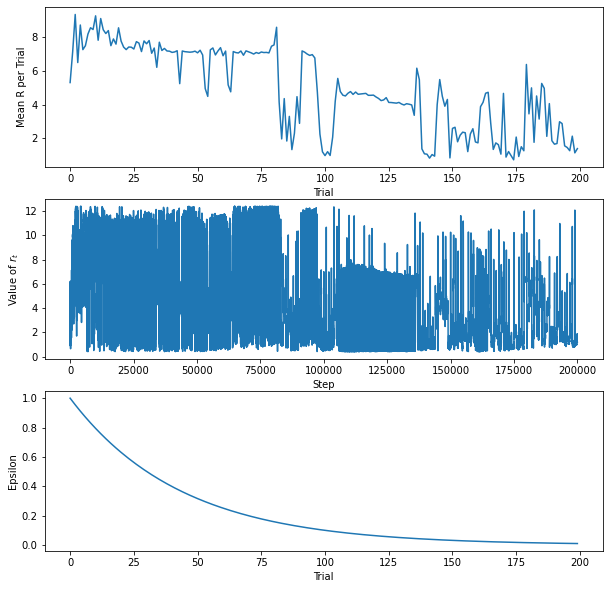

In [19]:
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon')

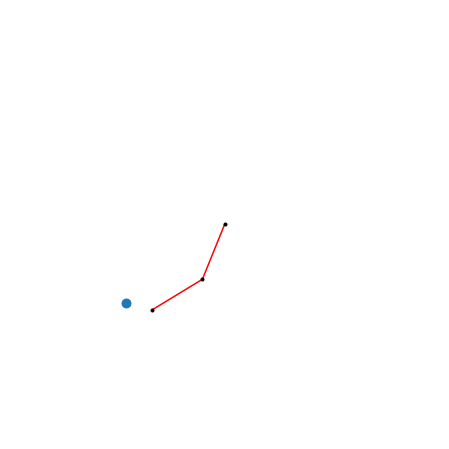

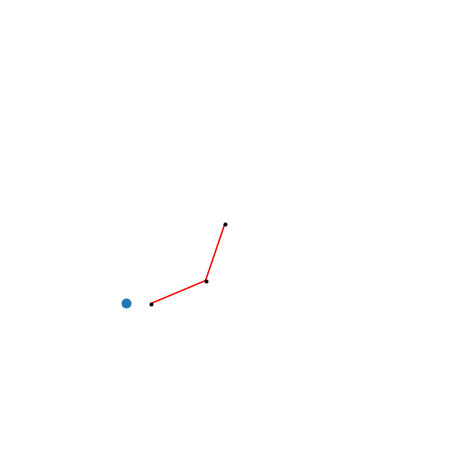

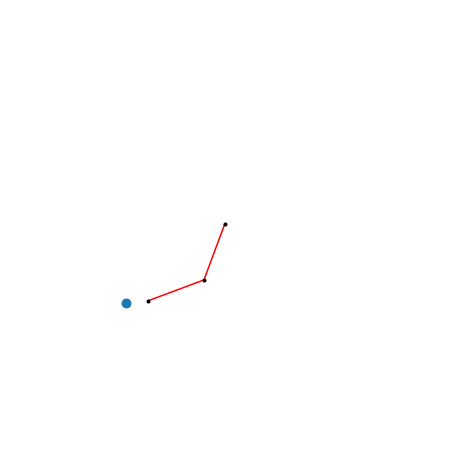

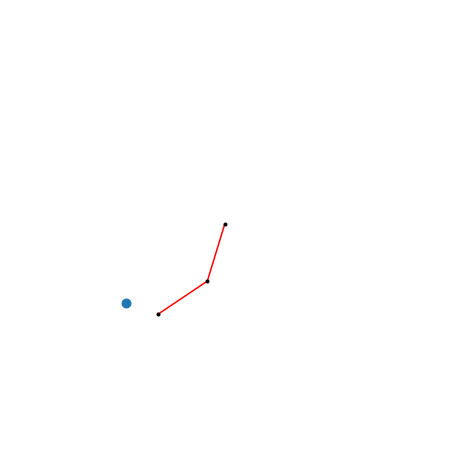

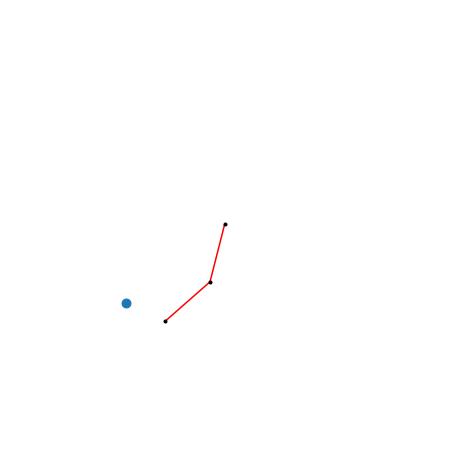

In [20]:
for i in range(5):
    initial_state(robot)
    robot.animate(100, Qnet)

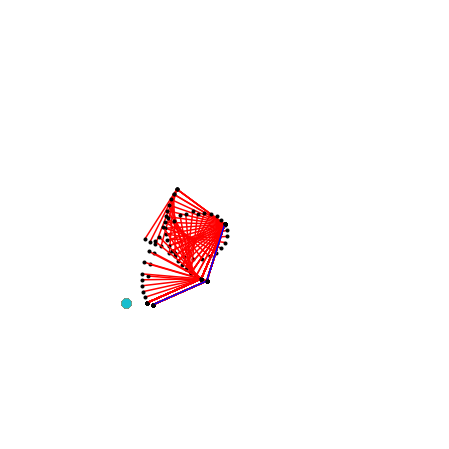

In [21]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

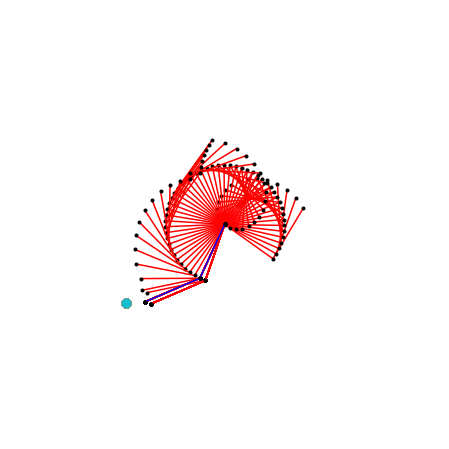

In [22]:
np.random.seed(4444)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

# Required Experiments

## Good parameter values

Find values for parameters `n_hiddens_list`, `n_trials`, `n_steps_per_trial`, `n_scg_iterations`, and `gamma` that result in Mean R per Trial plot that shows fairly steady decrease to value close to 0. 

In [23]:
# Trying out various values of the parameters

n_hiddens_lists = [[50, 10],[20], [10,10,10]]
n_trials = [200, 500, 250]
n_steps_per_trial = [500, 1000, 1500]
n_scg_iterations = [4, 6, 8]
final_epsilon = 0.01
gamma =[0.9, 0.4, 0.02]               


Trial 20: Mean R 6.31
Trial 40: Mean R 5.41
Trial 60: Mean R 4.75
Trial 80: Mean R 1.57
Trial 100: Mean R 1.62
Trial 120: Mean R 3.53
Trial 140: Mean R 5.15
Trial 160: Mean R 1.58
Trial 180: Mean R 1.91
Trial 200: Mean R 2.09


Text(0, 0.5, 'Mean R per Trial')

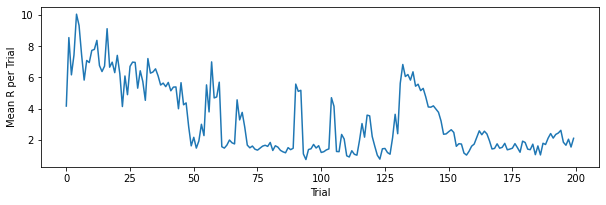

In [24]:
# Trying first set
# n_hiddens_lists = [50, 10]
# n_trials = 200
# n_steps_per_trial = 500
# n_scg_iterations = 4
# final_epsilon = 0.01
# gamma = 0.9

np.random.seed(42)
_, r_mean_trace_1, _, _ = train(robot, n_hiddens_lists[0], valid_actions, n_trials[0],
                                                   n_steps_per_trial[0], n_scg_iterations[0],
                                                   final_epsilon, gamma[0])
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace_1)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

Trial 50: Mean R 1.97
Trial 100: Mean R 0.63
Trial 150: Mean R 3.34
Trial 200: Mean R 1.09
Trial 250: Mean R 0.70
Trial 300: Mean R 6.52
Trial 350: Mean R 2.14
Trial 400: Mean R 0.51
Trial 450: Mean R 0.65
Trial 500: Mean R 0.51


Text(0, 0.5, 'Mean R per Trial')

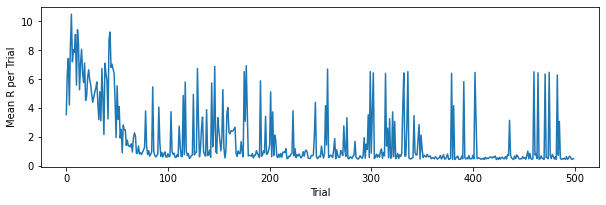

In [25]:
# Trying second set
# n_hiddens_lists = [20]
# n_trials = 500
# n_steps_per_trial = 1000
# n_scg_iterations = 6
# final_epsilon = 0.01
# gamma = 0.4

np.random.seed(42)
_, r_mean_trace_1, _, _ = train(robot, n_hiddens_lists[1], valid_actions, n_trials[1],
                                                   n_steps_per_trial[1], n_scg_iterations[1],
                                                   final_epsilon, gamma[1])


plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace_1)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

Trial 25: Mean R 3.51
Trial 50: Mean R 0.77
Trial 75: Mean R 1.75
Trial 100: Mean R 0.98
Trial 125: Mean R 0.59
Trial 150: Mean R 0.54
Trial 175: Mean R 0.75
Trial 200: Mean R 0.43
Trial 225: Mean R 0.49
Trial 250: Mean R 0.46


Text(0, 0.5, 'Mean R per Trial')

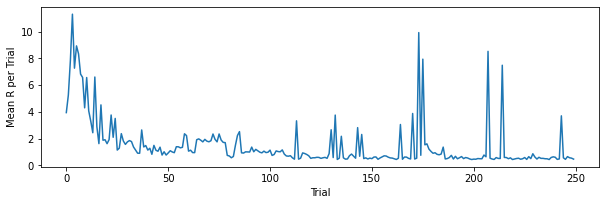

In [25]:
# Trying third set
# n_hiddens_lists = [10,10,10]
# n_trials = 250
# n_steps_per_trial = 1500
# n_scg_iterations = 8
# final_epsilon = 0.01
# gamma = 0.02

_, r_mean_trace_1, _, _ = train(robot, n_hiddens_lists[2], valid_actions, n_trials[2],
                                                   n_steps_per_trial[2], n_scg_iterations[2],
                                                   final_epsilon, gamma[2])


plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace_1)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

Trial 50: Mean R 4.11
Trial 100: Mean R 11.32
Trial 150: Mean R 1.17
Trial 200: Mean R 0.74
Trial 250: Mean R 0.83
Trial 300: Mean R 0.72
Trial 350: Mean R 1.08
Trial 400: Mean R 0.77
Trial 450: Mean R 0.54
Trial 500: Mean R 1.27


Text(0, 0.5, 'Mean R per Trial')

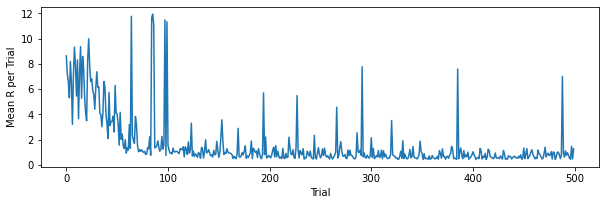

In [26]:
# Trying fourth set

# n_hiddens_lists = [50, 10]
# n_trials = 500
# n_steps_per_trial = 500
# n_scg_iterations = 8
# final_epsilon = 0.01
# gamma = 0.02

_, r_mean_trace_1, _, _ = train(robot, n_hiddens_lists[0], valid_actions, n_trials[1],
                                                   n_steps_per_trial[0], n_scg_iterations[2],
                                                   final_epsilon, gamma[2])

plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace_1)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

Trial 25: Mean R 4.00
Trial 50: Mean R 1.00
Trial 75: Mean R 1.11
Trial 100: Mean R 0.96
Trial 125: Mean R 2.05
Trial 150: Mean R 0.61
Trial 175: Mean R 0.72
Trial 200: Mean R 1.04
Trial 225: Mean R 0.94
Trial 250: Mean R 0.97


Text(0, 0.5, 'Mean R per Trial')

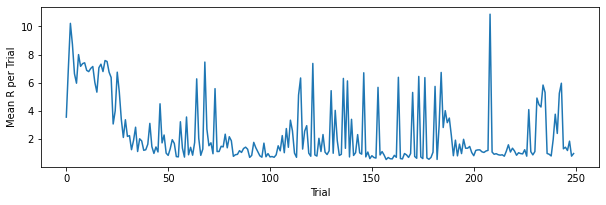

In [27]:
# Trying fifth set

# n_hiddens_lists = [20]
# n_trials = 250
# n_steps_per_trial = 1000
# n_scg_iterations = 6
# final_epsilon = 0.01
# gamma = 0.4

_, r_mean_trace_1, _, _ = train(robot, n_hiddens_lists[1], valid_actions, n_trials[2],
                                                   n_steps_per_trial[1], n_scg_iterations[1],
                                                   final_epsilon, gamma[1])


plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace_1)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

### Discussions.
The state of the robot arm is the angles of each joint.  
Thr robot arm has valid actions of $-0.1$, $0$, and $+0.1$ applied to each joint. The Q function is by varying various number of hidden_lists, n_trials, steps per trails, number of iterations, and gamma.
The R mean value for each trail was plotted.
The R mean vlaues obtained has sudden peak and sudden lower values for most of the parameters. This might be caused because of over training of the Q function.
The smoothly decreasing R mean value and minimum R mean was obtained when we use n_hidden_lists = [10,10,10], and n_trails = 250, n_steps_per_trails = 1500, n_scg_iterations = 8 and gamma = 0.02.




## Create robot with four links of lengths, 4, 3, 3,  and 2.

Again, find good values for the parameters. 

Create the robot_1 using links of lengths 4,3,3,2 from the class Robot. 
Then apply various different parameters that gives good values.

In [27]:
robot_1 = Robot([4., 3., 3., 2.])
robot_1.set_goal([5., 6.])

In [28]:
single_joint_actions = [-0.1, 0, 0.1]
valid_actions =  np.array(list(itertools.product(single_joint_actions, repeat=robot_1.n_links)))

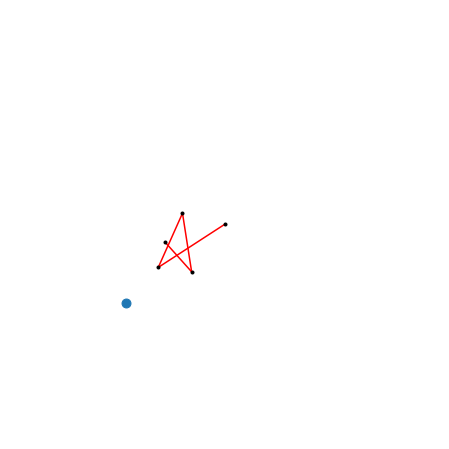

In [29]:
robot_1.animate(100)

In [30]:
n_hiddens_list = [50]
n_trials = 200
n_steps_per_trial = 1000
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)
Qnet_1, r_mean_trace_r, r_trace_r, epsilon_trace_r = train(robot_1, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations, final_epsilon, gamma)

Trial 20: Mean R 6.79
Trial 40: Mean R 4.35
Trial 60: Mean R 2.25
Trial 80: Mean R 2.29
Trial 100: Mean R 2.13
Trial 120: Mean R 1.40
Trial 140: Mean R 1.55
Trial 160: Mean R 1.15
Trial 180: Mean R 1.48
Trial 200: Mean R 0.93


Text(0, 0.5, 'Epsilon')

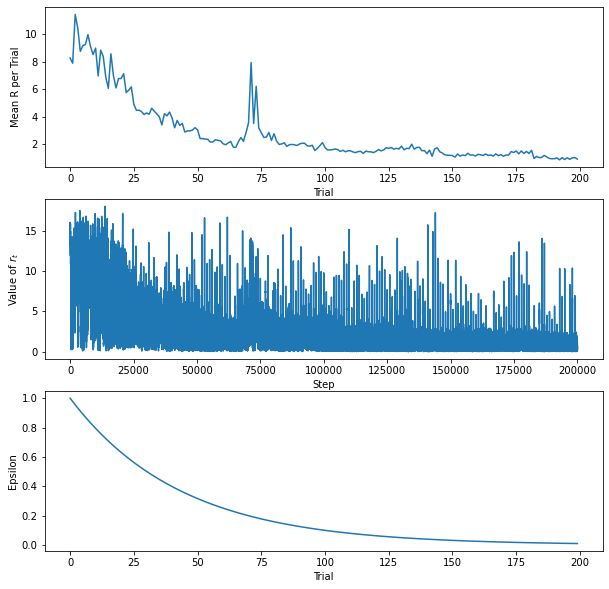

In [31]:
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace_r)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace_r)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace_r)
plt.xlabel('Trial')
plt.ylabel('Epsilon')

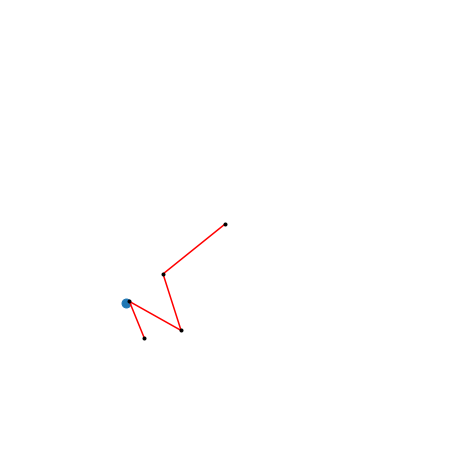

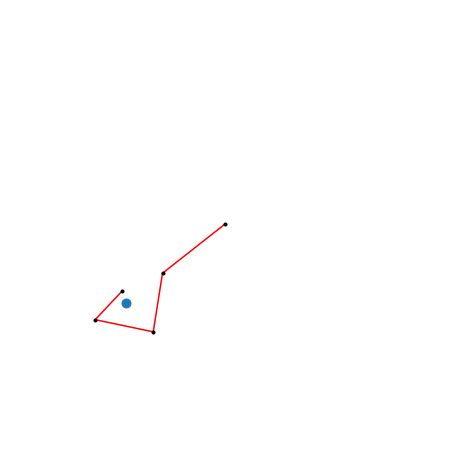

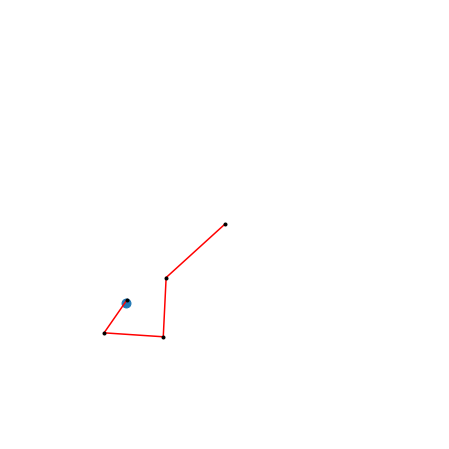

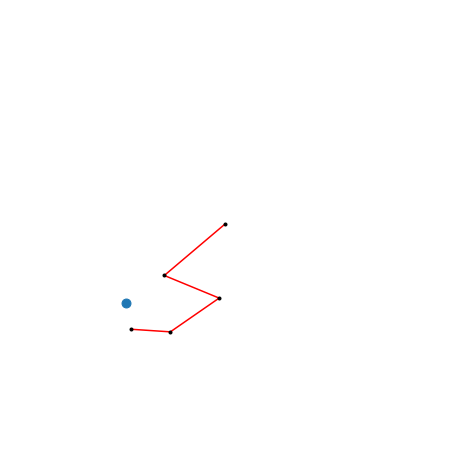

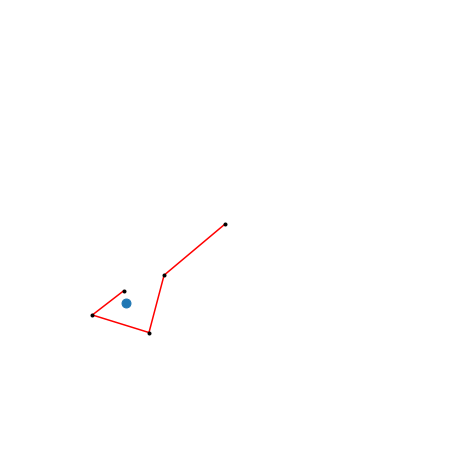

In [32]:
for i in range(5):
    initial_state(robot_1)
    robot_1.animate(100, Qnet_1)

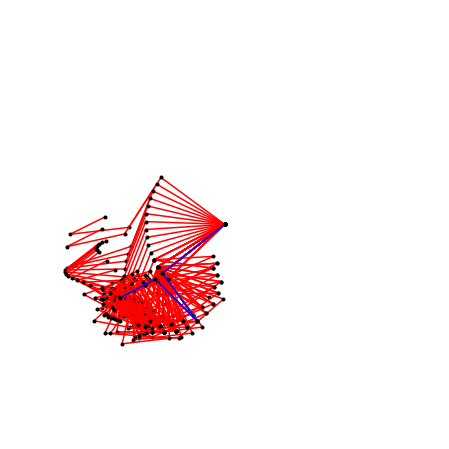

In [33]:
np.random.seed(1234)
initial_state(robot_1)
robot_1.animate(100, Qnet_1, show_all_steps=True)

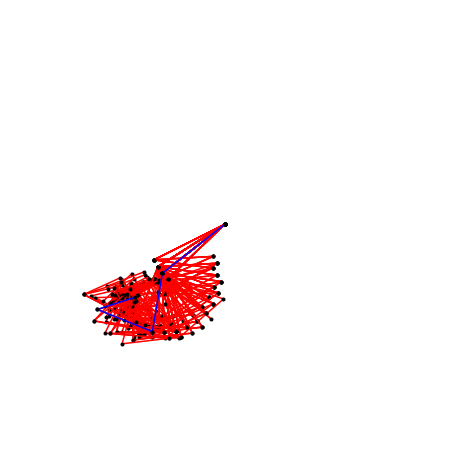

In [34]:
np.random.seed(4444)
initial_state(robot)
robot_1.animate(100, Qnet_1, show_all_steps=True)

Change the parameters and find the parameters that gives good values.

In [35]:
# Trying out various values of the parameters

n_hiddens_lists = [[50, 10],[20], [10,10,10]]
n_trials = [200, 500, 250]
n_steps_per_trial = [500, 1000, 1500]
n_scg_iterations = [4, 6, 8]
final_epsilon = 0.01
gamma =[0.9, 0.4, 0.02]  

Trial 20: Mean R 5.97
Trial 40: Mean R 8.00
Trial 60: Mean R 5.80
Trial 80: Mean R 6.90
Trial 100: Mean R 7.31
Trial 120: Mean R 5.17
Trial 140: Mean R 5.72
Trial 160: Mean R 5.77
Trial 180: Mean R 5.73
Trial 200: Mean R 5.90


Text(0, 0.5, 'Mean R per Trial')

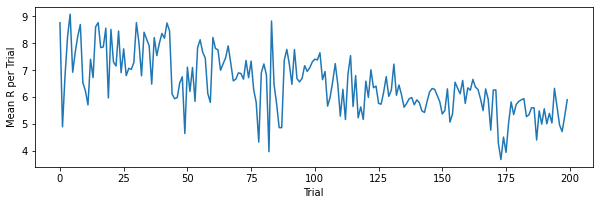

In [36]:
np.random.seed(42)
_, r_mean_trace_1, _, _ = train(robot_1, n_hiddens_lists[0], valid_actions, n_trials[0],
                                                   n_steps_per_trial[0], n_scg_iterations[0],
                                                   final_epsilon, gamma[0])
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace_1)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

Trial 50: Mean R 7.89
Trial 100: Mean R 4.44
Trial 150: Mean R 3.92
Trial 200: Mean R 3.32
Trial 250: Mean R 4.74
Trial 300: Mean R 7.45
Trial 350: Mean R 5.12
Trial 400: Mean R 5.45
Trial 450: Mean R 4.73
Trial 500: Mean R 6.29


Text(0, 0.5, 'Mean R per Trial')

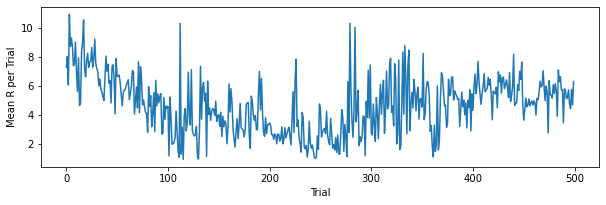

In [37]:
_, r_mean_trace_1, _, _ = train(robot_1, n_hiddens_lists[1], valid_actions, n_trials[1],
                                                   n_steps_per_trial[1], n_scg_iterations[1],
                                                   final_epsilon, gamma[1])
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace_1)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

Trial 20: Mean R 5.17
Trial 40: Mean R 4.40
Trial 60: Mean R 8.15
Trial 80: Mean R 3.32
Trial 100: Mean R 5.73
Trial 120: Mean R 5.60
Trial 140: Mean R 6.82
Trial 160: Mean R 5.55
Trial 180: Mean R 4.49
Trial 200: Mean R 8.69


Text(0, 0.5, 'Mean R per Trial')

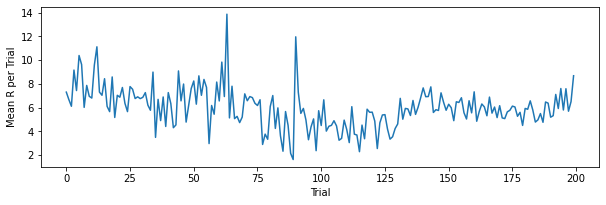

In [38]:
_, r_mean_trace_1, _, _ = train(robot_1, n_hiddens_lists[1], valid_actions, n_trials[0],
                                                   n_steps_per_trial[0], n_scg_iterations[0],
                                                   final_epsilon, gamma[1])
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace_1)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

Trial 50: Mean R 7.00
Trial 100: Mean R 6.43
Trial 150: Mean R 6.21
Trial 200: Mean R 13.99
Trial 250: Mean R 8.29
Trial 300: Mean R 4.22
Trial 350: Mean R 4.83
Trial 400: Mean R 7.66
Trial 450: Mean R 4.99
Trial 500: Mean R 3.36


Text(0, 0.5, 'Mean R per Trial')

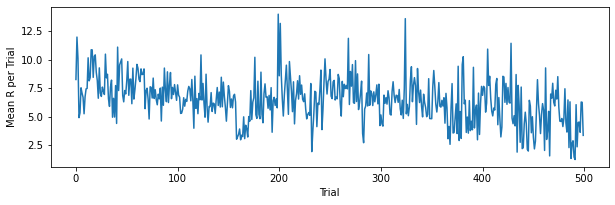

In [39]:
_, r_mean_trace_1, _, _ = train(robot_1, n_hiddens_lists[1], valid_actions, n_trials[1],
                                                   n_steps_per_trial[0], n_scg_iterations[0],
                                                   final_epsilon, gamma[2])
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace_1)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

Trial 20: Mean R 7.48
Trial 40: Mean R 5.43
Trial 60: Mean R 3.82
Trial 80: Mean R 2.69
Trial 100: Mean R 1.23
Trial 120: Mean R 1.79
Trial 140: Mean R 1.85
Trial 160: Mean R 2.91
Trial 180: Mean R 1.48
Trial 200: Mean R 3.45


Text(0, 0.5, 'Mean R per Trial')

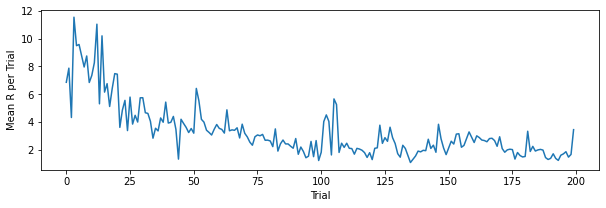

In [40]:
_, r_mean_trace_1, _, _ = train(robot_1, n_hiddens_lists[1], valid_actions, n_trials[0],
                                                   n_steps_per_trial[0], n_scg_iterations[1],
                                                   final_epsilon, gamma[0])
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace_1)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

### Discussion


A new robot arm "robot_1" is created using links of lengths 4,3,3,2 from the class Robot.Thr robot arm has valid actions of $-0.1$, $0$, and $+0.1$ applied to each joint.
The state of the robot arm is the angles of each joint.  
The Q function is trained by varying various number of hidden_lists, n_trials, steps per trails, number of iterations, and gamma to obtain good results.
The R mean value for each trail was plotted.
The R mean vlaues obtained has sudden peak and sudden lower values for most of the parameters. This might be caused because of over training of the Q function.
The smoothly decreasing R mean value and minimum R mean was obtained when we use n_hidden_lists = [50], and n_trails = 200, n_steps_per_trails = 1000, n_scg_iterations = 4 and gamma = 0.9.




## Increase number of valid actions

We have been using just three different actions for each joint, `[-0.1, 0, 0.1]`.  Allow more precision in the control by changing this list of valid actions for each joint to `[-0.1, -0.05, 0, 0.05, 0.1]`.

As before, find good values for the parameters.

Change the list of valid actions to [-0.1, -0.05, 0, 0.05, 0.1]. robot_2 is obtained from Robot() class
for list of valid actions. Change the parameters and observe the results to find the good results

In [41]:
robot_2 = Robot([3., 3.])
robot_2.set_goal([5., 6.])

In [42]:
single_joint_actions = [-0.1, -0.05, 0, 0.05, 0.1]
valid_actions =  np.array(list(itertools.product(single_joint_actions, repeat=robot_2.n_links)))

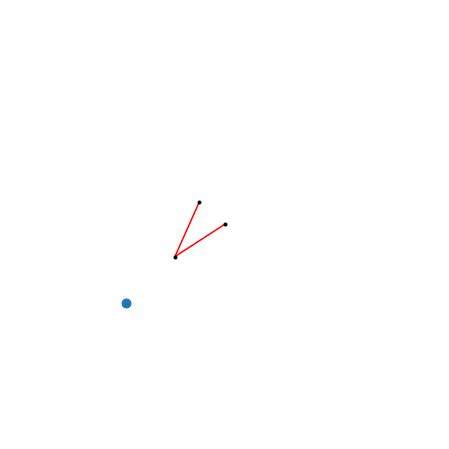

In [43]:
robot_2.animate(100)

In [44]:
n_hiddens_list = [50]
n_trials = 200
n_steps_per_trial = 1000
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)
Qnet_2, r_mean_trace_2, r_trace_2, epsilon_trace_2 = train(robot_2, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations, final_epsilon, gamma)

Trial 20: Mean R 9.51
Trial 40: Mean R 5.00
Trial 60: Mean R 3.69
Trial 80: Mean R 3.58
Trial 100: Mean R 1.44
Trial 120: Mean R 0.84
Trial 140: Mean R 0.78
Trial 160: Mean R 0.63
Trial 180: Mean R 0.75
Trial 200: Mean R 0.84


Text(0, 0.5, 'Epsilon')

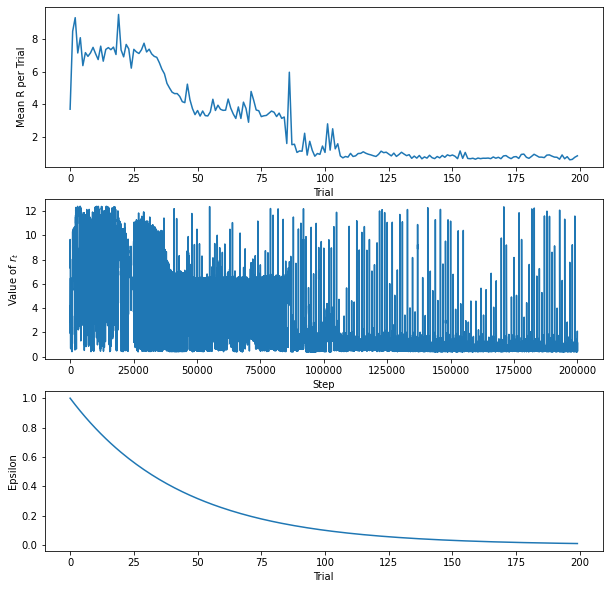

In [45]:
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace_2)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace_2)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace_2)
plt.xlabel('Trial')
plt.ylabel('Epsilon')

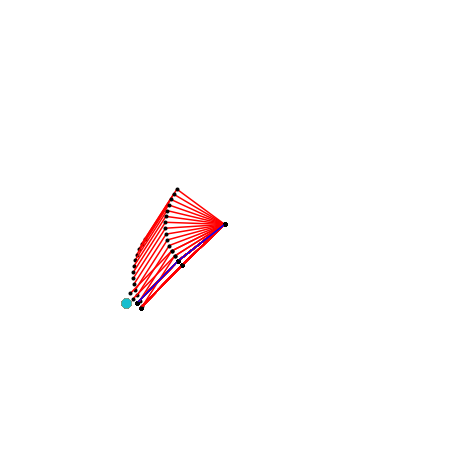

In [46]:
np.random.seed(1234)
initial_state(robot_2)
robot_2.animate(200, Qnet_2, show_all_steps=True)

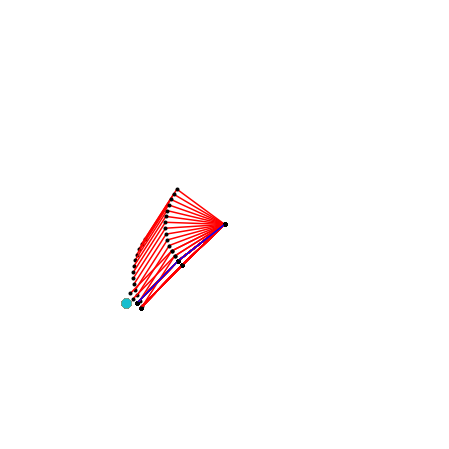

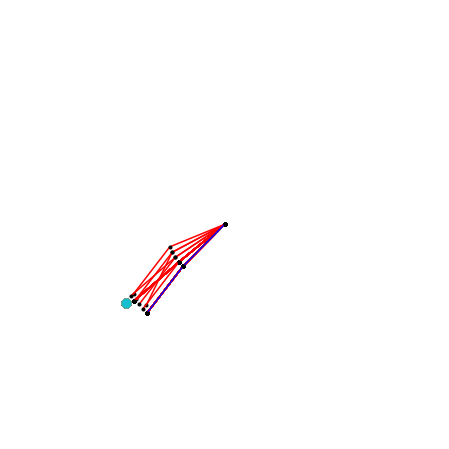

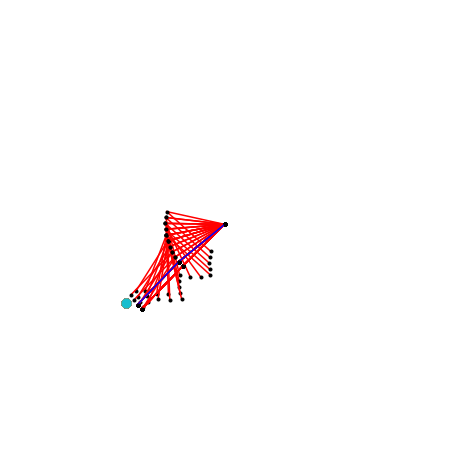

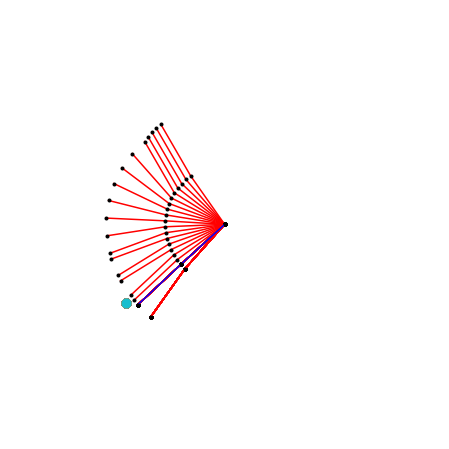

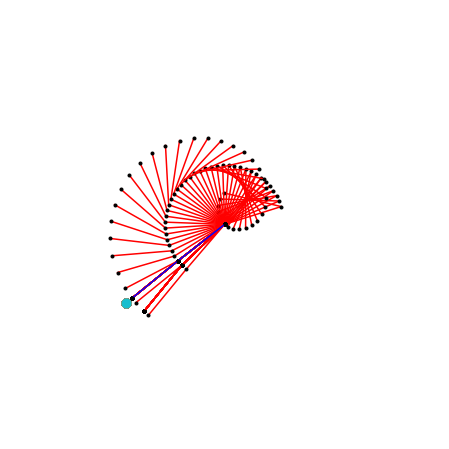

In [47]:
np.random.seed(1234)
for i in range(5):
    initial_state(robot_2)
    robot_2.animate(100, Qnet_2, show_all_steps=True)



In [50]:
# List of the various parameters that can be used to determine good values to predict
# the Robot arm movement.

n_hiddens_lists = [[50, 10],[50], [10,10,10]]
n_trials = [200, 500, 250]
n_steps_per_trial = [500, 1000, 1500]
n_scg_iterations = [4, 6, 8]
final_epsilon = 0.01
gamma =[0.9, 0.8, 0.5]

Trial 20: Mean R 4.71
Trial 40: Mean R 1.51
Trial 60: Mean R 2.63
Trial 80: Mean R 1.53
Trial 100: Mean R 0.69
Trial 120: Mean R 1.09
Trial 140: Mean R 1.24
Trial 160: Mean R 0.82
Trial 180: Mean R 1.42
Trial 200: Mean R 2.57


Text(0, 0.5, 'Mean R per Trial')

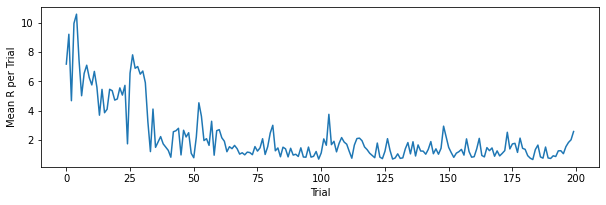

In [49]:
np.random.seed(42)
_, r_mean_trace_2, _, _ = train(robot_2, n_hiddens_lists[0], valid_actions, n_trials[0],
                                                   n_steps_per_trial[0], n_scg_iterations[0],
                                                   final_epsilon, gamma[0])
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace_2)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

Trial 50: Mean R 7.17
Trial 100: Mean R 0.78
Trial 150: Mean R 0.55
Trial 200: Mean R 0.53
Trial 250: Mean R 0.61
Trial 300: Mean R 0.57
Trial 350: Mean R 0.60
Trial 400: Mean R 0.64
Trial 450: Mean R 0.46
Trial 500: Mean R 0.50


Text(0, 0.5, 'Mean R per Trial')

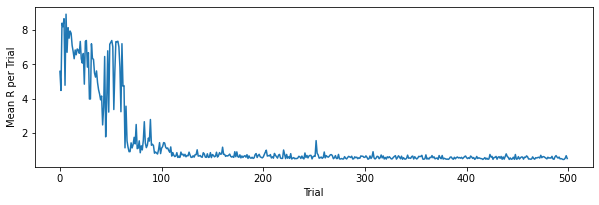

In [51]:
_, r_mean_trace_2, _, _ = train(robot_2, n_hiddens_lists[1], valid_actions, n_trials[1],
                                                   n_steps_per_trial[1], n_scg_iterations[1],
                                                   final_epsilon, gamma[1])
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace_2)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

Trial 25: Mean R 3.54
Trial 50: Mean R 1.57
Trial 75: Mean R 0.95
Trial 100: Mean R 0.66
Trial 125: Mean R 0.64
Trial 150: Mean R 0.55
Trial 175: Mean R 0.62
Trial 200: Mean R 0.46
Trial 225: Mean R 0.52
Trial 250: Mean R 0.58


Text(0, 0.5, 'Mean R per Trial')

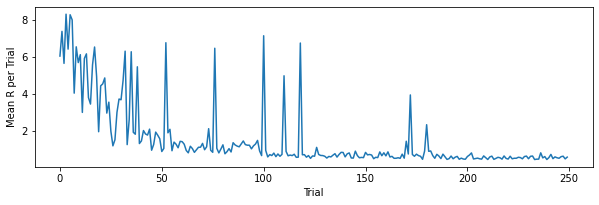

In [52]:

_, r_mean_trace_2, _, _ = train(robot_2, n_hiddens_lists[1], valid_actions, n_trials[2],
                                                   n_steps_per_trial[1], n_scg_iterations[2],
                                                   final_epsilon, gamma[2])
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace_2)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

Trial 50: Mean R 5.74
Trial 100: Mean R 3.15
Trial 150: Mean R 0.75
Trial 200: Mean R 0.64
Trial 250: Mean R 0.66
Trial 300: Mean R 0.70
Trial 350: Mean R 0.68
Trial 400: Mean R 0.59
Trial 450: Mean R 0.44
Trial 500: Mean R 0.56


Text(0, 0.5, 'Mean R per Trial')

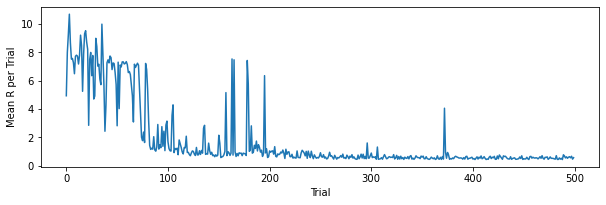

In [53]:

_, r_mean_trace_2, _, _ = train(robot_2, n_hiddens_lists[1], valid_actions, n_trials[1],
                                                   n_steps_per_trial[1], n_scg_iterations[0],
                                                   final_epsilon, gamma[2])
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace_2)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

Trial 20: Mean R 6.32
Trial 40: Mean R 6.66
Trial 60: Mean R 2.50
Trial 80: Mean R 0.81
Trial 100: Mean R 1.15
Trial 120: Mean R 0.71
Trial 140: Mean R 0.88
Trial 160: Mean R 0.78
Trial 180: Mean R 0.79
Trial 200: Mean R 1.08


Text(0, 0.5, 'Mean R per Trial')

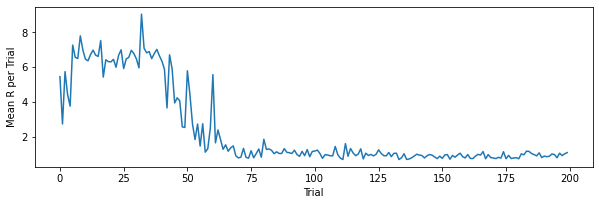

In [54]:

_, r_mean_trace_2, _, _ = train(robot_2, n_hiddens_lists[1], valid_actions, n_trials[0],
                                                   n_steps_per_trial[0], n_scg_iterations[1],
                                                   final_epsilon, gamma[0])
plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace_2)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

#### Discussion

A new robot arm "robot_2" is created using links of lengths 3, 3 from the class Robot.The robot arm has valid actions of [ -0.1, -0.05, 0.0, 0.05, 0.1] applied to each joint. The state of the robot arm is the angles of each joint.
The Q function is trained by varying various number of hidden_lists, n_trials, steps per trails, number of iterations, and gamma to obtain good results. The R mean value for each trail was plotted. The R mean vlaues obtained has sudden peak and sudden lower values for most of the parameters. This might be caused because of over training of the Q function. The smoothly decreasing R mean value and minimum R mean (0.5) was obtained when we use n_hidden_lists = [50], and n_trails = 500, n_steps_per_trails = 1000, n_scg_iterations = 6 and gamma = 0.8.




#### Conclusion

In this assignment a robot arm with multiple links, analogous to human hand with shoulder and knee joints. The end of the robot arm acts as hand (grapper) to grap a goal which is a ball in this assignment.
the Q function of the robot arm was trained to find best possible actions and results. The R mean value was observed thoughout the trails by varying various parameters to the neural network.
The neural network that trains the robot arm's Q function to give minimum R mean value was obtained for various type of robot arm (arm having 4 and 2 links, arm having 5 and 3 valid actions). 

# Extra Credit

As discussed in class for the marble control, make modifications to allow a variable goal.  Add the goal coordinates to the state input to the Qnet.  Demonstrate success by plotting `r_mean_trace` for four different, fixed, goals.